In [ ]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from hyperopt import fmin, tpe, hp, Trials


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your file on Google Drive
file_path = '/content/drive/My Drive/output_file.csv'  # Replace with your file's path

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the data to verify it loaded correctly
print(data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   id   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  50.0       2     168    62.0    110     80            1     1      0   
1   1  55.0       1     156    85.0    140     90            3     1      0   
2   2  52.0       1     165    64.0    130     70            3     1      0   
3   3  48.0       2     169    82.0    150    100            1     1      0   
4   4  48.0       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [ ]:
# Rename columns
data.columns = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

In [ ]:
# Step 1: Data Preparation
X = np.array(data.drop(['cardio'], axis=1))  # Features
y = np.array(data['cardio'])  # Target

In [ ]:
# Standardizing the data
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

In [ ]:
# Step 2: Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [33]:
# Convert target variable into categorical labels
Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)
print (Y_train.shape)
print (Y_train[:10])

(56000, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [34]:
# Build the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))
model.add(Dropout(0.3))

model.add(Dense(2, activation='sigmoid'))  # Final layer for binary classification

model.compile(optimizer=Adam(learning_rate=0.001, amsgrad=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to avoid overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[es], verbose=1)


Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6342 - loss: 0.6407 - val_accuracy: 0.7258 - val_loss: 0.5700
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7021 - loss: 0.5892 - val_accuracy: 0.7298 - val_loss: 0.5629
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7138 - loss: 0.5776 - val_accuracy: 0.7349 - val_loss: 0.5607
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7169 - loss: 0.5762 - val_accuracy: 0.7326 - val_loss: 0.5527
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7169 - loss: 0.5747 - val_accuracy: 0.7342 - val_loss: 0.5526
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7240 - loss: 0.5701 - val_accuracy: 0.7274 - val_loss: 0.5548
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7225 - loss: 0.5700 - val_accuracy: 0.7358 - val_loss: 0.5499
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7214 - loss

In [35]:
# Get predictions and evaluate the model
categorical_pred = np.argmax(model.predict(X_test), axis=1)
y_test_int = np.argmax(Y_test, axis=1)

# Print results
print('Results for Categorical Model')
print(f"Accuracy: {accuracy_score(y_test_int, categorical_pred)}")
print(classification_report(y_test_int, categorical_pred))

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Results for Categorical Model
Accuracy: 0.7202857142857143
              precision    recall  f1-score   support

           0       0.77      0.63      0.69      6988
           1       0.69      0.81      0.74      7012

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000



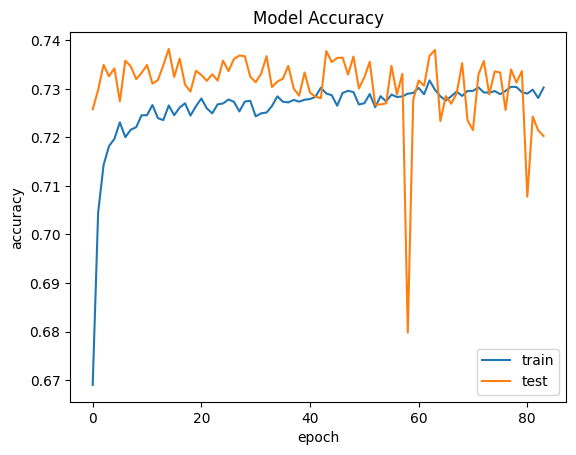

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

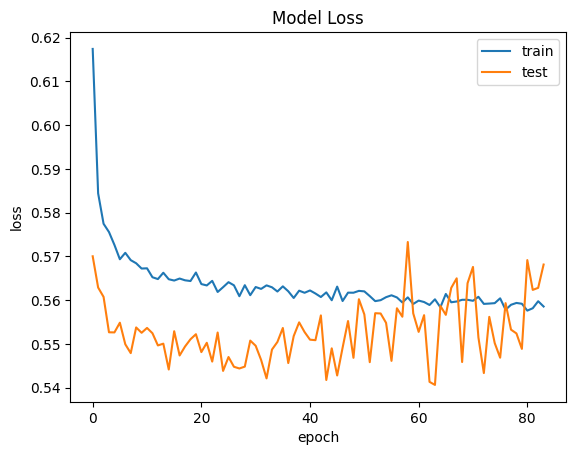

In [37]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()